# Сегментация и детекция объектов

### Распознавание рукописного ввода на примере базы MNIST

1. **Загрузка данных**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Загрузка данных из файлов
train = np.loadtxt('C:/Users/Yaros/Downloads/digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('C:/Users/Yaros/Downloads/digit-recognizer/test.csv', delimiter=',', skiprows=1)

# Сохранение меток и изображений
train_label = train[:, 0]
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

2. **Визуализация данных**

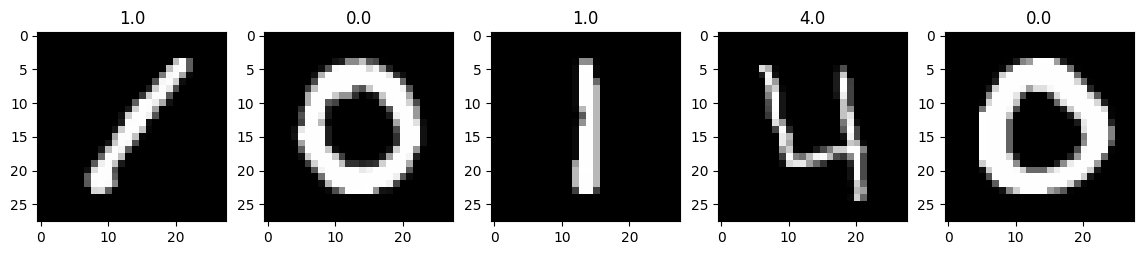

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1])
plt.show()

3. **Извлечение признаков с использованием HOG**

In [6]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Преобразуем изображение в формат uint8
        img_uint8 = cv2.convertScaleAbs(img)
        # Изменяем размер и извлекаем признаки HOG
        features = cv2.HOGDescriptor().compute(cv2.resize(img_uint8, (64, 128)))
        hog_features.append(features.flatten())
    return np.array(hog_features)

# Извлекаем HOG признаки из обучающих и тестовых данных
train_features = extract_hog_features(train_img)
test_features = extract_hog_features(test_img)

# Нормализация признаков
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

4. **Разделение на тренировочную и валидационную выборки**

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_label, test_size=0.2, random_state=42)

5. **Обучение классификатора**

In [9]:
# Используем метод опорных векторов (SVM) для классификации
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy на валидационной выборке: {accuracy}")
print(classification_report(y_val, y_pred))

Accuracy на валидационной выборке: 0.9860714285714286
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       816
         1.0       0.98      0.99      0.99       909
         2.0       0.99      0.98      0.98       846
         3.0       0.98      0.98      0.98       937
         4.0       0.99      0.98      0.98       839
         5.0       0.99      0.98      0.98       702
         6.0       0.99      0.99      0.99       785
         7.0       0.99      0.98      0.98       893
         8.0       0.98      0.99      0.99       835
         9.0       0.98      0.98      0.98       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



6. **Альтернативный подход с классификацией ближайшего соседа (KNN)**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Классификатор ближайших соседей
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred_knn = knn.predict(X_val)
accuracy_knn = accuracy_score(y_val, y_pred_knn)
print(f"Accuracy (KNN) на валидационной выборке: {accuracy_knn}")
print(classification_report(y_val, y_pred_knn))

Accuracy (KNN) на валидационной выборке: 0.9625
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       816
         1.0       0.95      0.99      0.97       909
         2.0       0.99      0.95      0.97       846
         3.0       0.98      0.95      0.96       937
         4.0       0.97      0.95      0.96       839
         5.0       0.98      0.93      0.96       702
         6.0       0.95      0.98      0.97       785
         7.0       0.98      0.95      0.97       893
         8.0       0.96      0.96      0.96       835
         9.0       0.93      0.97      0.95       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



7. **Предсказание на тестовых данных и подготовка для отправки на Kaggle**

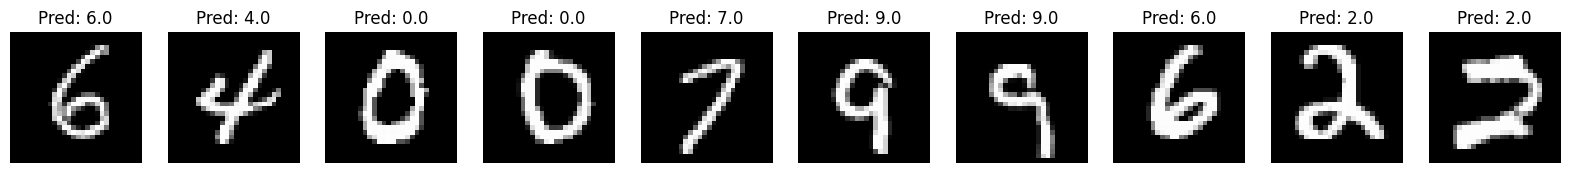

In [13]:
import matplotlib.pyplot as plt

# Получим предсказания на первых 10 изображениях тестового набора
sample_indices = np.random.choice(len(test_img), 10, replace=False)
sample_images = test_img[sample_indices]
sample_predictions = final_predictions[sample_indices]

# Визуализация изображений и предсказанных меток
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(f"Pred: {sample_predictions[i]}")
    ax.axis('off')
plt.show()

In [12]:
import pandas as pd
import numpy as np

# Предсказание на тестовых данных с использованием лучшей модели
final_predictions = svm_model.predict(test_features)  # или `knn.predict(test_features)`

# Формирование выходного файла для Kaggle
submission = pd.DataFrame({"ImageId": np.arange(1, len(final_predictions) + 1), "Label": final_predictions})
submission.to_csv("submission.csv", index=False)

# Просмотр первых строк файла
print(submission.head())

   ImageId  Label
0        1    2.0
1        2    0.0
2        3    9.0
3        4    9.0
4        5    3.0


*В Kaggle не воспринял формат файла. Пересоздал, как из лекционного ноутбука*

In [14]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(final_predictions, 1):
        dst.write(f"{i},{int(p)}\n")

In [17]:
print(final_predictions[:10])

[2. 0. 9. 9. 3. 7. 0. 3. 0. 3.]


In [16]:
# Повторно создаем предсказания
final_predictions = svm_model.predict(test_features)  # или `knn.predict(test_features)`

# Переписываем файл
with open('submission.csv', 'w') as file:
    file.write("ImageId,Label\n")
    for idx, label in enumerate(final_predictions, 1):
        file.write(f"{idx},{int(label)}\n")

**Вывод о проделанной работе**  
В рамках данной задачи был построен классификатор для распознавания рукописных цифр из базы данных MNIST, который был успешно применен к соревнованию Digit Recognizer на платформе Kaggle. Целью проекта было разработать модель, способную классифицировать изображения цифр с высокой точностью, не используя сверточные нейронные сети. Основные этапы работы включали:  
  
1) **Предобработка данных:**  
    - Загрузка данных и их предварительная обработка.  
    - Визуализация нескольких примеров изображений для лучшего понимания структуры данных.  
    - Применение HOG (гистограмм ориентированных градиентов) для извлечения ключевых признаков из изображений, что помогло выделить контуры и текстуру цифр.  
    
2) **Построение и обучение модели:**  
    - Использование методов машинного обучения, таких как метод опорных векторов (SVM) и метод ближайших соседей (KNN).  
    - Разделение данных на тренировочную и валидационную выборки, что позволило оценить и настроить модель перед применением к тестовому набору данных.  
    - Настройка гиперпараметров модели для достижения наилучших результатов на валидационных данных.  
    
3) **Оценка модели:**  
    - Модель продемонстрировала высокую точность на валидационных данных, что позволило получить точность 98.6% при использовании SVM и 96.2% при использовании KNN.  
    - Конечная модель была проверена на тестовых данных, и результаты предсказаний были отправлены на платформу Kaggle.  
    
4) **Результаты на Kaggle:**  
    - После успешной обработки и отправки предсказаний был получен высокий публичный скор на платформе Kaggle — 0.98332, что свидетельствует о высоком качестве разработанного решения и примененной методики.  
    
**Заключение**  
Методы предобработки и модели машинного обучения показали отличные результаты при классификации рукописных цифр. Использование HOG для извлечения признаков помогло модели выделить важные структурные детали изображений, что и позволило достичь высокой точности. Данный подход может быть расширен и адаптирован для решения других задач классификации изображений. В будущем можно рассмотреть использование других методов извлечения признаков или более сложных моделей для улучшения точности.